In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# **Primary data processing**
Let's open our dataset and make some changes to it for further analysis

In [0]:
dfm = pd.read_csv('./tmdb_5000_movies.csv')
dfm['release_date'] = pd.to_datetime(dfm['release_date'])

num_cols = ['budget', 'popularity',
            'revenue', 'runtime', 'vote_average', 'vote_count']
id_cols = ['id']

cat_cols = ['original_language']

target = ['revenue', 'popularity', 'vote_average']

dfm.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [0]:
dfm = dfm.drop(dfm[(dfm.revenue == 0) | (dfm.runtime == 0) | (dfm.budget == 0) | (dfm.popularity == 0)].index, axis=0)

len(dfm)

3229

In [0]:
import json

#Translate data to acceptable format by converting a JSON columns
prime_genre = pd.json_normalize(dfm.genres.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': 0, 'name': 'None'}))
secondary_genre = pd.json_normalize(dfm.genres.apply(json.loads).apply(lambda x: x[1] if (len(x) > 1) else {'id': 0, 'name': 'None'}))

#genres
dfm['prime_genre_id'] = prime_genre['id']
dfm['prime_genre_name'] = prime_genre['name']
dfm['secondary_genre_id'] = secondary_genre['id']
dfm['secondary_genre_name'] = secondary_genre['name']

#production country
dfm['prime_production_country_id'] = pd.json_normalize(dfm.production_countries.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'iso_3166_1': 'None', 'name': 'Unknown'}))['iso_3166_1']
dfm['prime_production_country_name'] = pd.json_normalize(dfm.production_countries.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'iso_3166_1': 'None', 'name': 'Unknown'}))['name']

#production company
dfm['production_company_id'] = pd.json_normalize(dfm.production_companies.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': 'None', 'name': 'Unknown'}))['id']
dfm['production_company_name'] = pd.json_normalize(dfm.production_companies.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': 'None', 'name': 'Unknown'}))['name']

#keywords
dfm['main_keyword_id'] = pd.json_normalize(dfm.keywords.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': '0', 'name': 'None'}))['id']
dfm['main_keyword'] = pd.json_normalize(dfm.keywords.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': '0', 'name': 'None'}))['name']
dfm['second_keyword_id'] = pd.json_normalize(dfm.keywords.apply(json.loads).apply(lambda x: x[1] if (len(x) > 1) else {'id': '0', 'name': 'None'}))['id']
dfm['second_keyword'] = pd.json_normalize(dfm.keywords.apply(json.loads).apply(lambda x: x[1] if (len(x) > 1) else {'id': '0', 'name': 'None'}))['name']

id_cols += ['prime_genre_id', 'secondary_genre_id', 'prime_production_country_id', 'main_keyword_id', 'second_keyword_id']
cat_cols += ['prime_genre_name', 'secondary_genre_name', 'main_keyword', 'second_keyword', 'production_company_name']
dfm = dfm.drop(['genres', 'homepage', 'original_title',
                'production_countries', 'production_companies', 'keywords',
                "tagline",	"title", 'overview',
                'spoken_languages'], axis=1)

In [0]:
dfm.sample(5)

,budget,id,original_language,popularity,release_date,revenue,runtime,status,vote_average,vote_count,prime_genre_id,prime_genre_name,secondary_genre_id,secondary_genre_name,prime_production_country_id,prime_production_country_name,production_company_id,production_company_name,main_keyword_id,main_keyword,second_keyword_id,second_keyword,profitable,foreign,rounded_runtime
3107,10000000,20178,en,9.805551,2009-08-20,295750,99.0,Released,6.5,177,27.0,Horror,53.0,Thriller,US,United States of America,1038,Bazelevs Production,6104,computer,6733,bullying,False,False,100.0
3439,6400000,218,en,74.234793,1984-10-26,78371200,108.0,Released,7.3,4128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,110.0
1072,45000000,17379,en,6.156015,2006-01-13,38399961,112.0,Released,6.4,119,28.0,Action,12.0,Adventure,US,United States of America,7405,Dimension Films,282,video game,2051,intelligence,False,False,110.0
3185,9000000,15568,en,2.365328,2007-06-01,2955039,97.0,Released,6.0,17,10402.0,Music,99.0,Documentary,US,United States of America,4,Paramount Pictures,897,rap music,898,hip-hop,False,False,100.0
873,46000000,479,en,19.643365,2000-06-15,107196498,99.0,Released,5.5,308,18.0,Drama,0.0,None,US,United States of America,5,Columbia Pictures,240,underdog,818,based on novel,False,False,100.0


# How can we classifice this data?
Some examples of classificating data about filmes, which show that target feature may be different

### By success of release

In [0]:
money_successful = dfm[(dfm.revenue / dfm.budget) > 2.5]
rating_succesful = dfm[(dfm.vote_average > 6.8) & (dfm.vote_count > dfm.vote_count.mean())]

money_failure = dfm[(dfm.revenue / dfm.budget) <= 1]
rating_failure = dfm[(dfm.vote_average < dfm.vote_average.mean())]

print(f'Count of successful by revenue films: {len(money_successful)}',
      f'Count of successful by rating films: {len(rating_succesful)}')

Count of successful by revenue films: 1515 Count of successful by rating films: 419


### By popularity

In [0]:
high_popularity = dfm[(dfm.popularity >= dfm.popularity.mean()) & (dfm.vote_count >= dfm.vote_count.median())]
low_popularity = dfm[(dfm.popularity <= dfm.popularity.mean()) & (dfm.vote_count <= dfm.vote_count.median())]

print(f'Count of popular films: {len(high_popularity)}',
      f'Count of unpopular films: {len(low_popularity)}')

Count of popular films: 1137 Count of unpopular films: 1615


## And what is the target feature? Let's find out!

From business point of view target feature is only one - profit. But we're dealing with cinematograph, which means that we can't just rely on money-oriented data, because every movie have a value in culture, society and all that... 

All this means, that we need 2 targets - First will show us commerce success **(revenue)**, Second will show culture/society success **(popularity)**

# Feature engineering and visualizing
Now we can generate new features, using current data




In [0]:
dfm['profitable'] = (dfm.revenue / dfm.budget) > 2.5

dfm['foreign'] = (dfm.prime_production_country_id) != 'US'


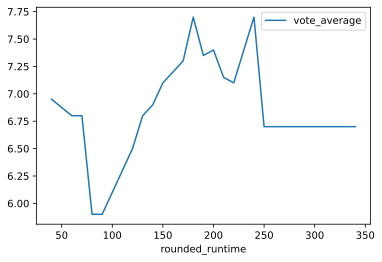

In [0]:
#Try to visualize depending between runtime and average of films
dfm['rounded_runtime'] = dfm['runtime'].apply(lambda x: round(x, -1))
runtime_to_av = dfm[['rounded_runtime', 'vote_average']].groupby('rounded_runtime').median()

"""
As we can see, this depending grows on interval from 90 to 150,
and also other intervals have much anomalies, which formed because 
we have a little information about this intervals
"""
runtime_to_av.plot()

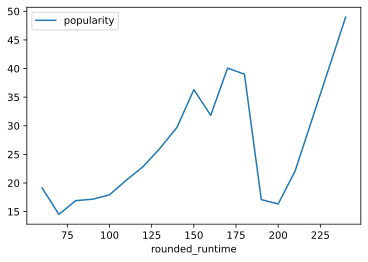

In [0]:
runtime_to_pop = dfm[['rounded_runtime', 'popularity']].groupby('rounded_runtime').median()

runtime_to_pop[runtime_to_pop.popularity > 14].plot() 

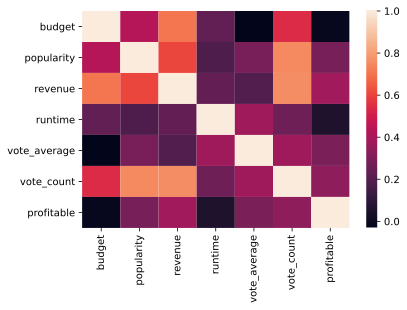

In [0]:
sns.heatmap(dfm[num_cols + ['profitable']].corr())

Vote count have good correlation with budget, revenue and popularity of film. 

Also our targets (**revenue**, popularity) have good correlation between themselves

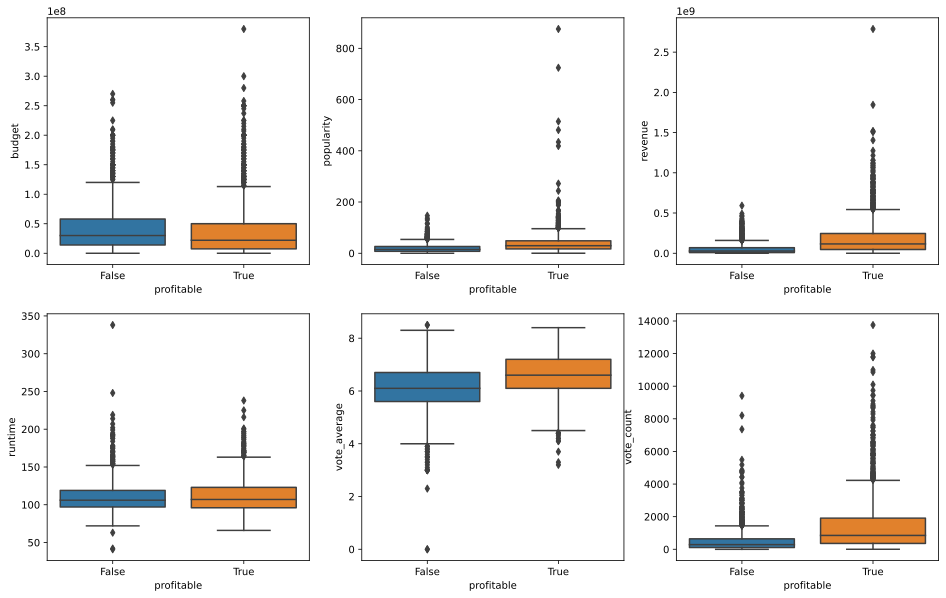

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

for idx, feature in enumerate(num_cols):
  sns.boxplot(x='profitable', y=feature, 
              data=dfm, 
              ax=axes[idx // 3, idx % 3])

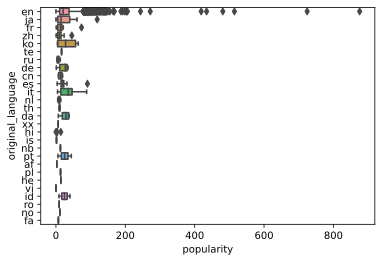

In [0]:
sns.boxplot(y='original_language', x='popularity', data=dfm)

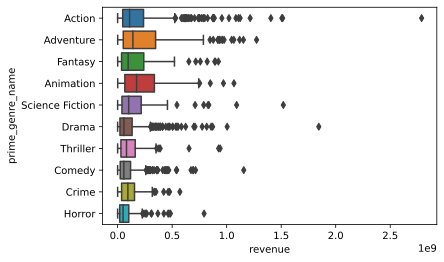

In [0]:
top_genres = dfm.prime_genre_name.value_counts().sort_values(ascending=False).head(10).index.values

sns.boxplot(y='prime_genre_name', x='revenue', data=dfm[dfm.prime_genre_name.isin(top_genres)])

# Hypotheses!
We need 2-3 hypotheses about target features, that's can predict theirs behavioral.

Let's put forward several hypotheses

1. Popularity, profitability and revenue of film more correlate with count of votes, and less with average of votes and popularity. First hypotesys:

  **If film promise to be profitable and popular, it will have much of votes and conversely**

2. Films with prime genres **'Animation'**, **'Adventure'**, **'Action'**, **'Science Fiction'** and **'Fantasy'** by median and qvartiles have more revenue than other by 1.5-3 times, and that's mean:

 **If film belong to "Golden 5", it will have more chances to be profitable**

3. Popularity of films on English, Korean, Japanese and Italian-speaking auditory much more than others. Maybe it's because cinema-industry in this countries more developed than others. Third hypotesys:

 **If film will be released on one of '4 wonderful languages', it will embrace bigger auditory and have more popularity**